# Learning Pandas

From [Python Pandas Tutorial: A Complete Introduction for Beginners](https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/)

In [8]:
import pandas as pd

The core components of pandas are `Series` and `DataFrame`.

A `Series` is a column, a `DataFrame` a multi-dimensional table made up of a collection of Series.
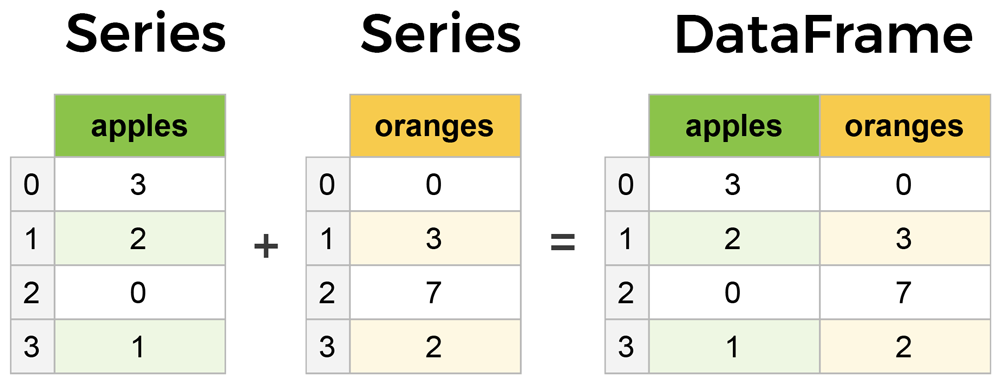

\[ Source: https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/ \]

## Creating DataFrames
The easiest way to create a DataFrame is to use a `dict`

In [9]:
data = {
    'apples': [3, 2, 0, 1],
    'oranges': [0, 3, 7, 2]
}

purchases = pd.DataFrame(data)

purchases

,apples,oranges
0,3,0
1,2,3
2,0,7
3,1,2


The **Index** for this `DataFrame` is coming from the lists, but we could have defined a different one when creating the `DataFrame`

In [12]:
index = ['June', 'Robert', 'Lily', 'David']
purchases = pd.DataFrame(data, index = index)

purchases

,apples,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


It possible to **loc**ate an order by index


In [16]:
purchases.loc['June']

apples     3
oranges    0
Name: June, dtype: int64

## Reading data from CSV

In [17]:
df = pd.read_csv('purchases.csv')

df

,Unnamed: 0,apple,oranges
0,June,3,0
1,Robert,2,3
2,Lily,0,7
3,David,1,2


We can specify what coumn is the index


In [18]:
df = pd.read_csv('purchases.csv', index_col=0)

df

,apple,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


## Reading from JSON
Pandas can read easily from JSON as well, the advantage of JSON is index are already built in through nesting

In [60]:
df = pd.read_json("purchases.json")

df

,apples,oranges
June,3,0
Robert,2,3
Lily,0,7
David,1,2


Note the structure of the json file, it is already saved in a *columnar* way, sometimes the *argument* `orient` keeds to be used to instruct how to read a json file.

## Reading from SQL
Data can also be read from a SQL DB, the author is using SQLite.

In [ ]:
!pip install pysqlite3


In [22]:
import sqlite3

con = sqlite3.connect("database.db")

In this SQLite DB, there is a table called *purchases* and the index is in a column called *"index"*.
Reading is as simple as running a SELECT query and `con`

In [67]:
query = 'SELECT * FROM purchases'
df = pd.read_sql_query(query, con)

df

,index,apples,oranges
0,June,3,0
1,Robert,2,3
2,Lily,0,7
3,David,1,2


As in CSV, it is possible to pass `index_col = 'index'`, but it is also possible to define an index using `set_index`:

In [59]:
df = df.set_index('index')

df


,apples,oranges
index,,
June,3,0
Robert,2,3
Lily,0,7
David,1,2


### Using BigQuery
I am going to do the same using the BQ libraries, because I am running this in AI Notebooks, it will use the Service Account associated to the instance hosting the notebook, make sure the AIM permissions allow to query BQ.

In [42]:
from google.cloud import bigquery
client = bigquery.Client(location="EU")
print("Client created using default project: {}".format(client.project))

Client created using default project: raffo-bq-xperiment


Run the same query as before, the table is pblicly available to anybody with a Google ID.

In [69]:
query = """
    SELECT * 
    FROM `raffo-bq-xperiment.learning.purchases`
"""

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="EU",
)  # API request - starts the query

df = query_job.to_dataframe()
df.set_index('index')

,apples,oranges
index,,
June,3,0
Robert,2,3
Lily,0,7
David,1,2


## Saving dataframes
Converting back is just the opposite process

In [26]:
df.to_csv('new_purchases.csv')

In [27]:
df.to_json('new_purchases.json')

In [28]:
df.to_sql('new_purchases', con)

We can then verify the new table has been added:

In [33]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master where type='table'")
cursor.fetchall()

[('purchases',), ('new_purchases',)]

And confirm verify its content:

In [73]:
cursor.execute("SELECT * FROM new_purchases")
cursor.fetchall()

[('June', 3, 0), ('Robert', 2, 3), ('Lily', 0, 7), ('David', 1, 2)]

#### Saving the DataFrame to BQ
First we need a dataset, we can create one:

or use and existing one:

In [70]:
dataset_id = 'learning'
dataset = client.dataset(dataset_id)

Then we save the table

In [71]:
table_ref = dataset.table("new_purchases")
# Important, if we don't do this the load_table_from_dataframe will fail
job = client.load_table_from_dataframe(df.reset_index(), table_ref, location="EU")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Loaded dataframe to /projects/raffo-bq-xperiment/datasets/learning/tables/new_purchases


## Common DataFrame operations
Let's work on the IMDB dataset:


In [128]:
movies_df = pd.read_csv("IMDB-Movie-Data.csv", index_col="Title")

### Viewing the data
When working with a large dataset, it is possible to print few lines to have a preview using `.head()`:

In [129]:
movies_df.head()

,Rank,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
Split,3,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
Sing,4,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
Suicide Squad,5,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


`head()` shows the first **5 lines** by default, similarly `.tail()` shows the last few lines, for example to see the last 2 lines:

In [76]:
movies_df.tail(2)

,Rank,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
Title,,,,,,,,,,,
Search Party,999,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,NaN,22.0
Nine Lives,1000,"Comedy,Family,Fantasy",A stuffy businessman finds himself trapped ins...,Barry Sonnenfeld,"Kevin Spacey, Jennifer Garner, Robbie Amell,Ch...",2016,87,5.3,12435,19.64,11.0


### Getting info
`.info()` provides a plethora of informations on the dataframe

In [77]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, Guardians of the Galaxy to Nine Lives
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Genre               1000 non-null   object 
 2   Description         1000 non-null   object 
 3   Director            1000 non-null   object 
 4   Actors              1000 non-null   object 
 5   Year                1000 non-null   int64  
 6   Runtime (Minutes)   1000 non-null   int64  
 7   Rating              1000 non-null   float64
 8   Votes               1000 non-null   int64  
 9   Revenue (Millions)  872 non-null    float64
 10  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 93.8+ KB


Not going to repeat the article, but this is good to give an overview of the dataset, for example it shows column 9 and 10 have few null values.

Another useful attribute is `.shape` which is a tuple(rows, columns):

In [79]:
movies_df.shape


(1000, 11)

### Handling duplicates
This dataset is duplicate-free, let's append it to itself using `.append()` to create duplicates:

In [80]:
temp_df = movies_df.append(movies_df)
temp_df.shape

(2000, 11)

This has created a copy of the *DataFrame*, similarly `.drop_duplicates()` will create a copy without duplicates.
The `inplace` flag will modify the DataFrame in place:

In [82]:
temp_df.drop_duplicates(inplace=True)
temp_df.shape

(1000, 11)

`keep` controls which duplicate we should keep, possible values are:
  * `first`
  * `last`
  * `False`
`first` and `last` have the same effect in this example, however, using `False` would end up removing all duplicated rows:

In [85]:
temp_df = movies_df.append(temp_df) # make a new copy
temp_df.drop_duplicates(inplace = True, keep = False)
temp_df.shape

(0, 11)

### Column cleanup
Datasets can have messy column names, to select by column easily we want to clean it.

The attribute `.columns` has the column names:

In [86]:
movies_df.columns

Index(['Rank', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')

The `.rename()` method can be used to change columns names using a `dict`.

For example, we want to remove the parenteses:


In [135]:
movies_df.rename(columns={
    'Runtime (Minutes)': 'Runtime',
    'Revenue (Millions)': 'Revenue',
},
    inplace=True
)

movies_df.columns

Index(['Rank', 'Genre', 'Description', 'Director', 'Actors', 'Year', 'Runtime',
       'Rating', 'Votes', 'Revenue', 'Metascore'],
      dtype='object')

It is also possible to rename all columns by modifying directly the `.colums` attribute


In [136]:
movies_df.columns = ['rank', 'genre', 'description', 'director', 'actors', 'year', 'runtime', 
                     'rating', 'votes', 'revenue_millions', 'metascore']


movies_df.columns

Index(['rank', 'genre', 'description', 'director', 'actors', 'year', 'runtime',
       'rating', 'votes', 'revenue_millions', 'metascore'],
      dtype='object')

### Working w missing values
Sometimes Dataset have empty values, tehre are 2 options for dealing with them:
  1. Get rid of rows or columns w Nulls
  2. Replace nulls w non-null values - this is known as **imputation**
  
First, let's see how many nulls we have:

In [94]:
movies_df.isnull()

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Guardians of the Galaxy,False,False,False,False,False,False,False,False,False,False,False
Prometheus,False,False,False,False,False,False,False,False,False,False,False
Split,False,False,False,False,False,False,False,False,False,False,False
Sing,False,False,False,False,False,False,False,False,False,False,False
Suicide Squad,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
Secret in Their Eyes,False,False,False,False,False,False,False,False,False,True,False
Hostel: Part II,False,False,False,False,False,False,False,False,False,False,False
Step Up 2: The Streets,False,False,False,False,False,False,False,False,False,False,False


This returns a `DataFrame`, the easiest way to count the *nulls* is to use `.sum()`:


In [96]:
movies_df.isnull().sum()

rank                  0
genre                 0
description           0
director              0
actors                0
year                  0
runtime               0
rating                0
votes                 0
revenue_millions    128
metascore            64
dtype: int64

Much more readable!

Let's go with **Option1** and remove all the rows with nulls

In [132]:
movies_df.dropna().shape

(838, 11)

#### Dropping nulls
Maybe it was better dropping columns afterall..

In [133]:
movies_df.dropna(axis=1).shape

(1000, 9)

Note: `axis=1` comes from the shape of the DataFrame, in this case means columns.

#### Imputation
This is a feature engineering technique to keep data that have nulls.

For example, in the `revenue_millions` colum, we can replace nulls with the **mean** or the **median** for the colum.

Let's first calculate the mean:

In [137]:
revenue = movies_df['revenue_millions']
revenue_mean = revenue.mean()

revenue_mean


82.95637614678897

Now we can fill all the null with the mean value obtained above

In [138]:
revenue.fillna(revenue_mean, inplace=True)

Having filled the nulls in `revenue` with the mean using `inplace=True`, the action is reflected in the DataFrame

In [139]:
movies_df.isnull().sum()

rank                 0
genre                0
description          0
director             0
actors               0
year                 0
runtime              0
rating               0
votes                0
revenue_millions     0
metascore           64
dtype: int64

There are other ways to explore the dataset.

`describe()` shows the distrubution of continous variables:


In [108]:
movies_df.describe()

,rank,year,runtime,rating,votes,revenue_millions,metascore
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,936.000000
mean,500.500000,2012.783000,113.172000,6.723200,1.698083e+05,82.956376,58.985043
std,288.819436,3.205962,18.810908,0.945429,1.887626e+05,96.412043,17.194757
min,1.000000,2006.000000,66.000000,1.900000,6.100000e+01,0.000000,11.000000
25%,250.750000,2010.000000,100.000000,6.200000,3.630900e+04,17.442500,47.000000
50%,500.500000,2014.000000,111.000000,6.800000,1.107990e+05,60.375000,59.500000
75%,750.250000,2016.000000,123.000000,7.400000,2.399098e+05,99.177500,72.000000
max,1000.000000,2016.000000,191.000000,9.000000,1.791916e+06,936.630000,100.000000


`.describe()` can also be used on a variable to count rows, unique counte of cathegories, top and frequent.


In [109]:
movies_df['genre'].describe()

count                        1000
unique                        207
top       Action,Adventure,Sci-Fi
freq                           50
Name: genre, dtype: object

`.value_countes()` instead tells the frequency of all values in a column:


In [110]:
movies_df['genre'].value_counts().head(10)

Action,Adventure,Sci-Fi       50
Drama                         48
Comedy,Drama,Romance          35
Comedy                        32
Drama,Romance                 31
Animation,Adventure,Comedy    27
Comedy,Drama                  27
Action,Adventure,Fantasy      27
Comedy,Romance                26
Crime,Drama,Thriller          24
Name: genre, dtype: int64

#### Relationship between continous variables
The correlation method `.corr()` shows the relationship between each continous variable

In [111]:
movies_df.corr()


,rank,year,runtime,rating,votes,revenue_millions,metascore
rank,1.000000,-0.261605,-0.221739,-0.219555,-0.283876,-0.252996,-0.191869
year,-0.261605,1.000000,-0.164900,-0.211219,-0.411904,-0.117562,-0.079305
runtime,-0.221739,-0.164900,1.000000,0.392214,0.407062,0.247834,0.211978
rating,-0.219555,-0.211219,0.392214,1.000000,0.511537,0.189527,0.631897
votes,-0.283876,-0.411904,0.407062,0.511537,1.000000,0.607941,0.325684
revenue_millions,-0.252996,-0.117562,0.247834,0.189527,0.607941,1.000000,0.133328
metascore,-0.191869,-0.079305,0.211978,0.631897,0.325684,0.133328,1.000000


This is a bivariate relationship table.

#### Slicing, selecting and extracting

##### By Column
To extract a column is a simple as getting a value out of a `dict`

In [113]:
genre_col = movies_df['genre']

type(genre_col)

pandas.core.series.Series

A column is a **Series**, to extract a set of columns as a **DataFrame**, pass a list of column names - sigle item in this case:

In [114]:
genre_col = movies_df[['genre']]

type(genre_col)

pandas.core.frame.DataFrame

Or multiple columns:

In [115]:
subset = movies_df[['genre', 'rating']]

subset.head()

,genre,rating
Title,,
Guardians of the Galaxy,"Action,Adventure,Sci-Fi",8.1
Prometheus,"Adventure,Mystery,Sci-Fi",7.0
Split,"Horror,Thriller",7.3
Sing,"Animation,Comedy,Family",7.2
Suicide Squad,"Action,Adventure,Fantasy",6.2


##### By row
We have 2 options here:
  * `.loc` - by name
  * `.iloc` - by index
  

In [117]:
prom = movies_df.loc["Prometheus"]

prom

rank                                                                2
genre                                        Adventure,Mystery,Sci-Fi
description         Following clues to the origin of mankind, a te...
director                                                 Ridley Scott
actors              Noomi Rapace, Logan Marshall-Green, Michael Fa...
year                                                             2012
runtime                                                           124
rating                                                              7
votes                                                          485820
revenue_millions                                               126.46
metascore                                                          65
Name: Prometheus, dtype: object

The result is a Series

In [118]:
type(prom)

pandas.core.series.Series

Alternatively, we can use `iloc`, using the numeric index value:


In [121]:
prom = movies_df.iloc[1]

Both `loc` and `iloc` behave similarly to Python `list` *slicing*

For example, where in Python you can use `example_list[1:4]` in Pandas works in a similar way:

In [124]:
movie_subset = movies_df['Prometheus':'Sing']
movie_subset = movies_df[1:4]

movie_subset

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
Split,3,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
Sing,4,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0


The biggest difference is that `.loc` includes the last item in the slice, whereas `.iloc` behaves like a Python list slice.

##### Conditional selection
Let's assume we want to filter the movies directed by Ridely Scott.


In [126]:
condition = (movies_df['director'] == "Ridley Scott")

condition.head()

Title
Guardians of the Galaxy    False
Prometheus                  True
Split                      False
Sing                       False
Suicide Squad              False
Name: director, dtype: bool

The condition is a *Series* with True and False values.
To filter movies non directed by Ridley Scott, we need to pass the condition in the DF.

In [142]:
movies_df[movies_df['director'] == 'Ridley Scott']

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
The Martian,103,"Adventure,Drama,Sci-Fi",An astronaut becomes stranded on Mars after hi...,Ridley Scott,"Matt Damon, Jessica Chastain, Kristen Wiig, Ka...",2015,144,8.0,556097,228.43,80.0
Robin Hood,388,"Action,Adventure,Drama","In 12th century England, Robin and his band of...",Ridley Scott,"Russell Crowe, Cate Blanchett, Matthew Macfady...",2010,140,6.7,221117,105.22,53.0
American Gangster,471,"Biography,Crime,Drama","In 1970s America, a detective works to bring d...",Ridley Scott,"Denzel Washington, Russell Crowe, Chiwetel Eji...",2007,157,7.8,337835,130.13,76.0
Exodus: Gods and Kings,517,"Action,Adventure,Drama",The defiant leader Moses rises up against the ...,Ridley Scott,"Christian Bale, Joel Edgerton, Ben Kingsley, S...",2014,150,6.0,137299,65.01,52.0
The Counselor,522,"Crime,Drama,Thriller",A lawyer finds himself in over his head when h...,Ridley Scott,"Michael Fassbender, Penélope Cruz, Cameron Dia...",2013,117,5.3,84927,16.97,48.0
A Good Year,531,"Comedy,Drama,Romance",A British investment broker inherits his uncle...,Ridley Scott,"Russell Crowe, Abbie Cornish, Albert Finney, M...",2006,117,6.9,74674,7.46,47.0
Body of Lies,738,"Action,Drama,Romance",A CIA agent on the ground in Jordan hunts down...,Ridley Scott,"Leonardo DiCaprio, Russell Crowe, Mark Strong,...",2008,128,7.1,182305,39.38,57.0


This applies to numeral values as well:

In [143]:
movies_df[movies_df['rating'] >= 8.6].head(3)

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Interstellar,37,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99,74.0
The Dark Knight,55,"Action,Crime,Drama",When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",2008,152,9.0,1791916,533.32,82.0
Inception,81,"Action,Adventure,Sci-Fi","A thief, who steals corporate secrets through ...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",2010,148,8.8,1583625,292.57,74.0


It is also possible to use conditional `|` and `&`.

For example, this is filtering with movies only by Christopher Nolan or Ridley Scott:


In [144]:
movies_df[(movies_df['director']=="Christopher Nolan") | (movies_df['director']  == "Ridley Scott")].head()

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
Interstellar,37,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99,74.0
The Dark Knight,55,"Action,Crime,Drama",When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",2008,152,9.0,1791916,533.32,82.0
The Prestige,65,"Drama,Mystery,Sci-Fi",Two stage magicians engage in competitive one-...,Christopher Nolan,"Christian Bale, Hugh Jackman, Scarlett Johanss...",2006,130,8.5,913152,53.08,66.0
Inception,81,"Action,Adventure,Sci-Fi","A thief, who steals corporate secrets through ...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",2010,148,8.8,1583625,292.57,74.0


The `.isin()` method makes it more readable:


In [145]:
movies_df[movies_df['director'].isin(['Christopher Nolan', "Ridley Scott"])].head()

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
Interstellar,37,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99,74.0
The Dark Knight,55,"Action,Crime,Drama",When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",2008,152,9.0,1791916,533.32,82.0
The Prestige,65,"Drama,Mystery,Sci-Fi",Two stage magicians engage in competitive one-...,Christopher Nolan,"Christian Bale, Hugh Jackman, Scarlett Johanss...",2006,130,8.5,913152,53.08,66.0
Inception,81,"Action,Adventure,Sci-Fi","A thief, who steals corporate secrets through ...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",2010,148,8.8,1583625,292.57,74.0


**Exercise:** get all the movies that were released between 2005 and 2010, with a rating above 8.0 but made below the 25th percentile in revenues.

In [156]:
movies_df[
    ( (movies_df['year'] >= 2005) & (movies_df['year'] <= 2010) )
    & (movies_df['rating'] > 8.0)
    & (movies_df['revenue_millions'] < movies_df['revenue_millions'].quantile(0.25))
]

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore
Title,,,,,,,,,,,
3 Idiots,431,"Comedy,Drama",Two friends are searching for their long lost ...,Rajkumar Hirani,"Aamir Khan, Madhavan, Mona Singh, Sharman Joshi",2009,170,8.4,238789,6.52,67.0
The Lives of Others,477,"Drama,Thriller","In 1984 East Berlin, an agent of the secret po...",Florian Henckel von Donnersmarck,"Ulrich Mühe, Martina Gedeck,Sebastian Koch, Ul...",2006,137,8.5,278103,11.28,89.0
Incendies,714,"Drama,Mystery,War",Twins journey to the Middle East to discover t...,Denis Villeneuve,"Lubna Azabal, Mélissa Désormeaux-Poulin, Maxim...",2010,131,8.2,92863,6.86,80.0
Taare Zameen Par,992,"Drama,Family,Music",An eight-year-old boy is thought to be a lazy ...,Aamir Khan,"Darsheel Safary, Aamir Khan, Tanay Chheda, Sac...",2007,165,8.5,102697,1.20,42.0


The `.quantile()` methods returns the value of the xth percentile.

It is also possible to apply a function to the dataset with `apply()`

For example, we can transform the rating in **good** if is over 8.0 or **bad**

First, we need a function:

In [157]:
def rating_function(rating):
    if rating >= 8.0:
        return "good"
    else:
        return "bad"

Now we can apply it, first note this will return a Series

In [158]:
custom_rating = movies_df['rating'].apply(rating_function)

type(custom_rating)

pandas.core.series.Series

We can add the new Series to the DF as if we were inserting an element in a `dict`:

In [159]:
movies_df['rating_category'] = custom_rating

movies_df.head(2)

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore,rating_category
Title,,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0,good
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0,bad


It is possible to use a `lambda` function in a very functional way:

In [167]:
movies_df['rating'].apply(lambda x: "good" if x >= 0.80 else "bad")

Title
Guardians of the Galaxy    good
Prometheus                 good
Split                      good
Sing                       good
Suicide Squad              good
                           ... 
Secret in Their Eyes       good
Hostel: Part II            good
Step Up 2: The Streets     good
Search Party               good
Nine Lives                 good
Name: rating, Length: 1000, dtype: object

## Plotting

*Pandas* integrates w *Matplotlib*, it is then possible to plot directly from DataFrames and Series
First, let's import matplotlib

In [ ]:
!pip install Matplotlib

In [169]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # adjust font and plot size

Plotting the relationship between **rating** and **revenues**:

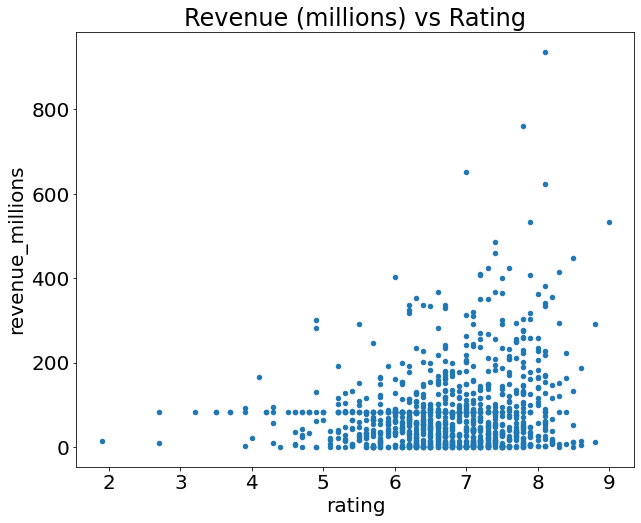

In [175]:
movies_df.plot(kind='scatter', x='rating', y='revenue_millions', title='Revenue (millions) vs Rating');

What about Histograms?

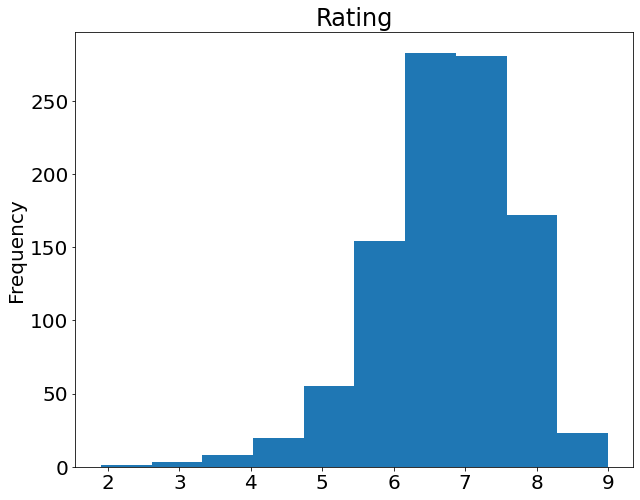

In [176]:
movies_df['rating'].plot(kind='hist', title='Rating');

`Boxplot` represents the interquartile range, similar to `.describe()`

In [177]:
movies_df['rating'].describe()

count    1000.000000
mean        6.723200
std         0.945429
min         1.900000
25%         6.200000
50%         6.800000
75%         7.400000
max         9.000000
Name: rating, dtype: float64

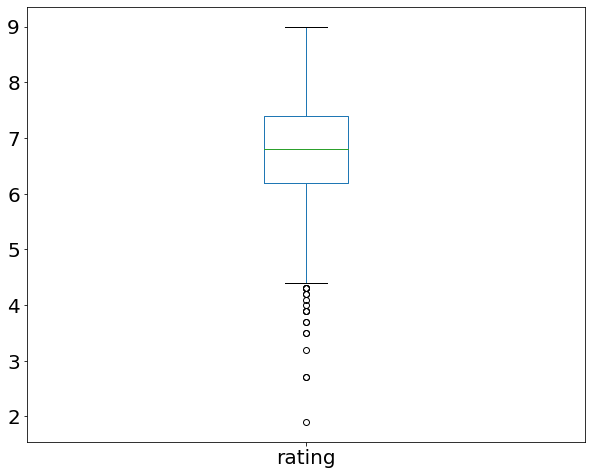

In [178]:
movies_df['rating'].plot(kind='box');

Finally, grouping categorical and continous data, it is possible to create a *Boxplot* of revenue that is grouped by the Ranting Category:

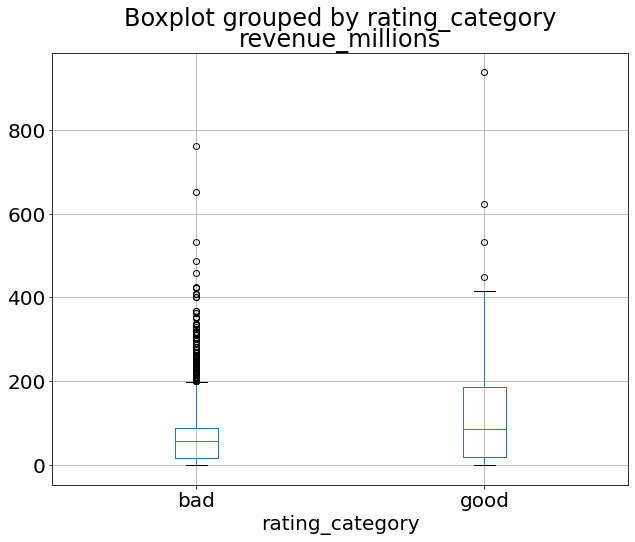

In [179]:
movies_df.boxplot(column='revenue_millions', by='rating_category');